# Learning Continuous Attractor Grid Cell Networks

## Table of Contents
* Introduction & Background
* Learning
    * Weight Patterns
* Simulation
* Assessement
* Conclusion


## Introduction & Background
Grid cells, located in the entorhinal cortex, are hypothesized to form the basis of the brain's system for navigation (If you're not familiar with grid cells at all, try reading [this article](https://www.nytimes.com/2013/04/30/science/how-grid-cells-in-brain-help-map-out-space.html) by the New York Times).  Although the existence and importance of grid cells is now well-established, precisely how grid cell networks function and learn remains something of an open question.  Today, one of the most popular models for grid cells is the continuous attractor network (CAN) model demonstrated by [Burak & Fiete, 2009](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1000291), in which properly-structured recurrent connections between grid cells allow them to accurately keep track of changes in an animal's location even without sensory cues, a process known as path integration.  In a later paper, [Widloski & Fiete, 2014](https://www.sciencedirect.com/science/article/pii/S0896627314005406?_rdoc=1&_fmt=high&_origin=gateway&_docanchor=&md5=b8429449ccfc9c30159a5f9aeaa92ffb "Read the paper") proposed a model for how such a network might be learned, using nothing more complex than Hebbian learning in a familiar home environment.

This Jupyter notebook contains code based on their paper for learning a continuous attractor grid cell network for navigation in a 1D environment, adapted to use rate-coding neurons. The experiments in this notebook can all be freely modified (play with the parameters!).  If you want to go even deeper, the Python code implementing the network can be obtained from the Htmresearch repository.

The network we learn has three different populations of neurons, two excitatory and one inhibitory.  The excitatory neurons are broken down into one group hardwired to prefer "left" movement, and another that is hardwired to prefer
"right" movement. It lacks connections between excitatory neurons; all CAN dynamics are based on
inhibition.

In this formulation, each grid cell begins as being sensitive to one, and only one, region in the "home" environment used for learning; we can sort them by location preference to visualize them in 1D space. The general setup of the problem can be visualized as the following (picture from Widloski & Fiete):


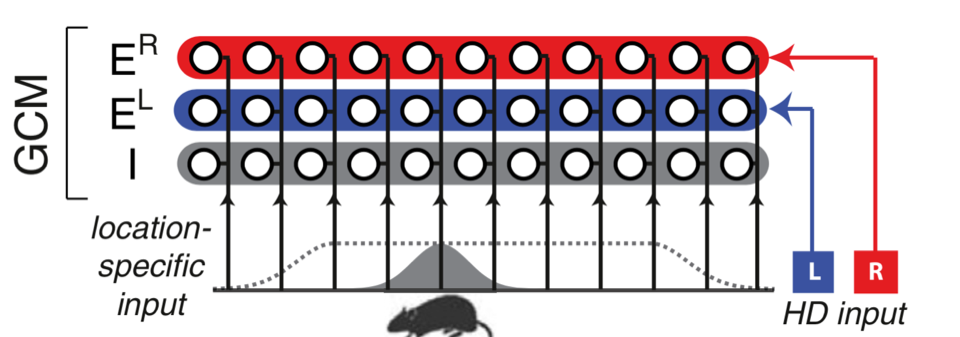

During training, the animal moves back and forth across the space, with cells in each population activated together according to their location preference.  The excitatory cells preferring left movement will be active primarily when the animal runs left across the environment; likewise, the right-preferring cells will be active during rightward runs.  This causes the development of asymmetric weight patterns that enable path integration, as we will later see.

In [115]:
# Imports and notebook statements
%load_ext autoreload
%autoreload 2
%matplotlib notebook

from htmresearch.frameworks.grid_cell_learning.CAN import CAN1DNetwork
import numpy as np
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150
import seaborn as sns
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We initialize a network with 200 cells in each excitatory population, and 200 inhibitory cells.

In [102]:
network = CAN1DNetwork(numExcitatory=200,
                       numInhibitory=200,
                       learningRate=50,
                       dt=0.01, # Time step for numerical integration
                       decayConstant=.03, # Decay rate of neuronal activation
                       stdpWindow=0.1/dt, # How long a time window to use for STDP updates.
                       )

## Learning

We then set the animal to move back and forth across the environment (shown in the top two figures).  Note that here we are treating the environment as being toroidal; this is simply a convenient simplifying assumption, and the same results can be achieved (albeit with slightly poorer path integration) if the environment is treated as being bounded.

During this learning process, observe the matrix of inhibitory-inhibitory connections (bottom figure).  As the animal proceeds back and forth across the environment, a distinct banded structure emerges, where inhibitory cells inhibit cells a fixed distance away from them, but do not inhibit cells very close to themselves.  This is roughly equivalent to the "Mexican hat" connectivity pattern sometimes associated with CAN networks.

Note also that we disable the recurrent connections between cells during training; they are still be learned, but they will not contribute to activation.  This is, unfortunately, required for numerical stability.

<IPython.core.display.Javascript object>


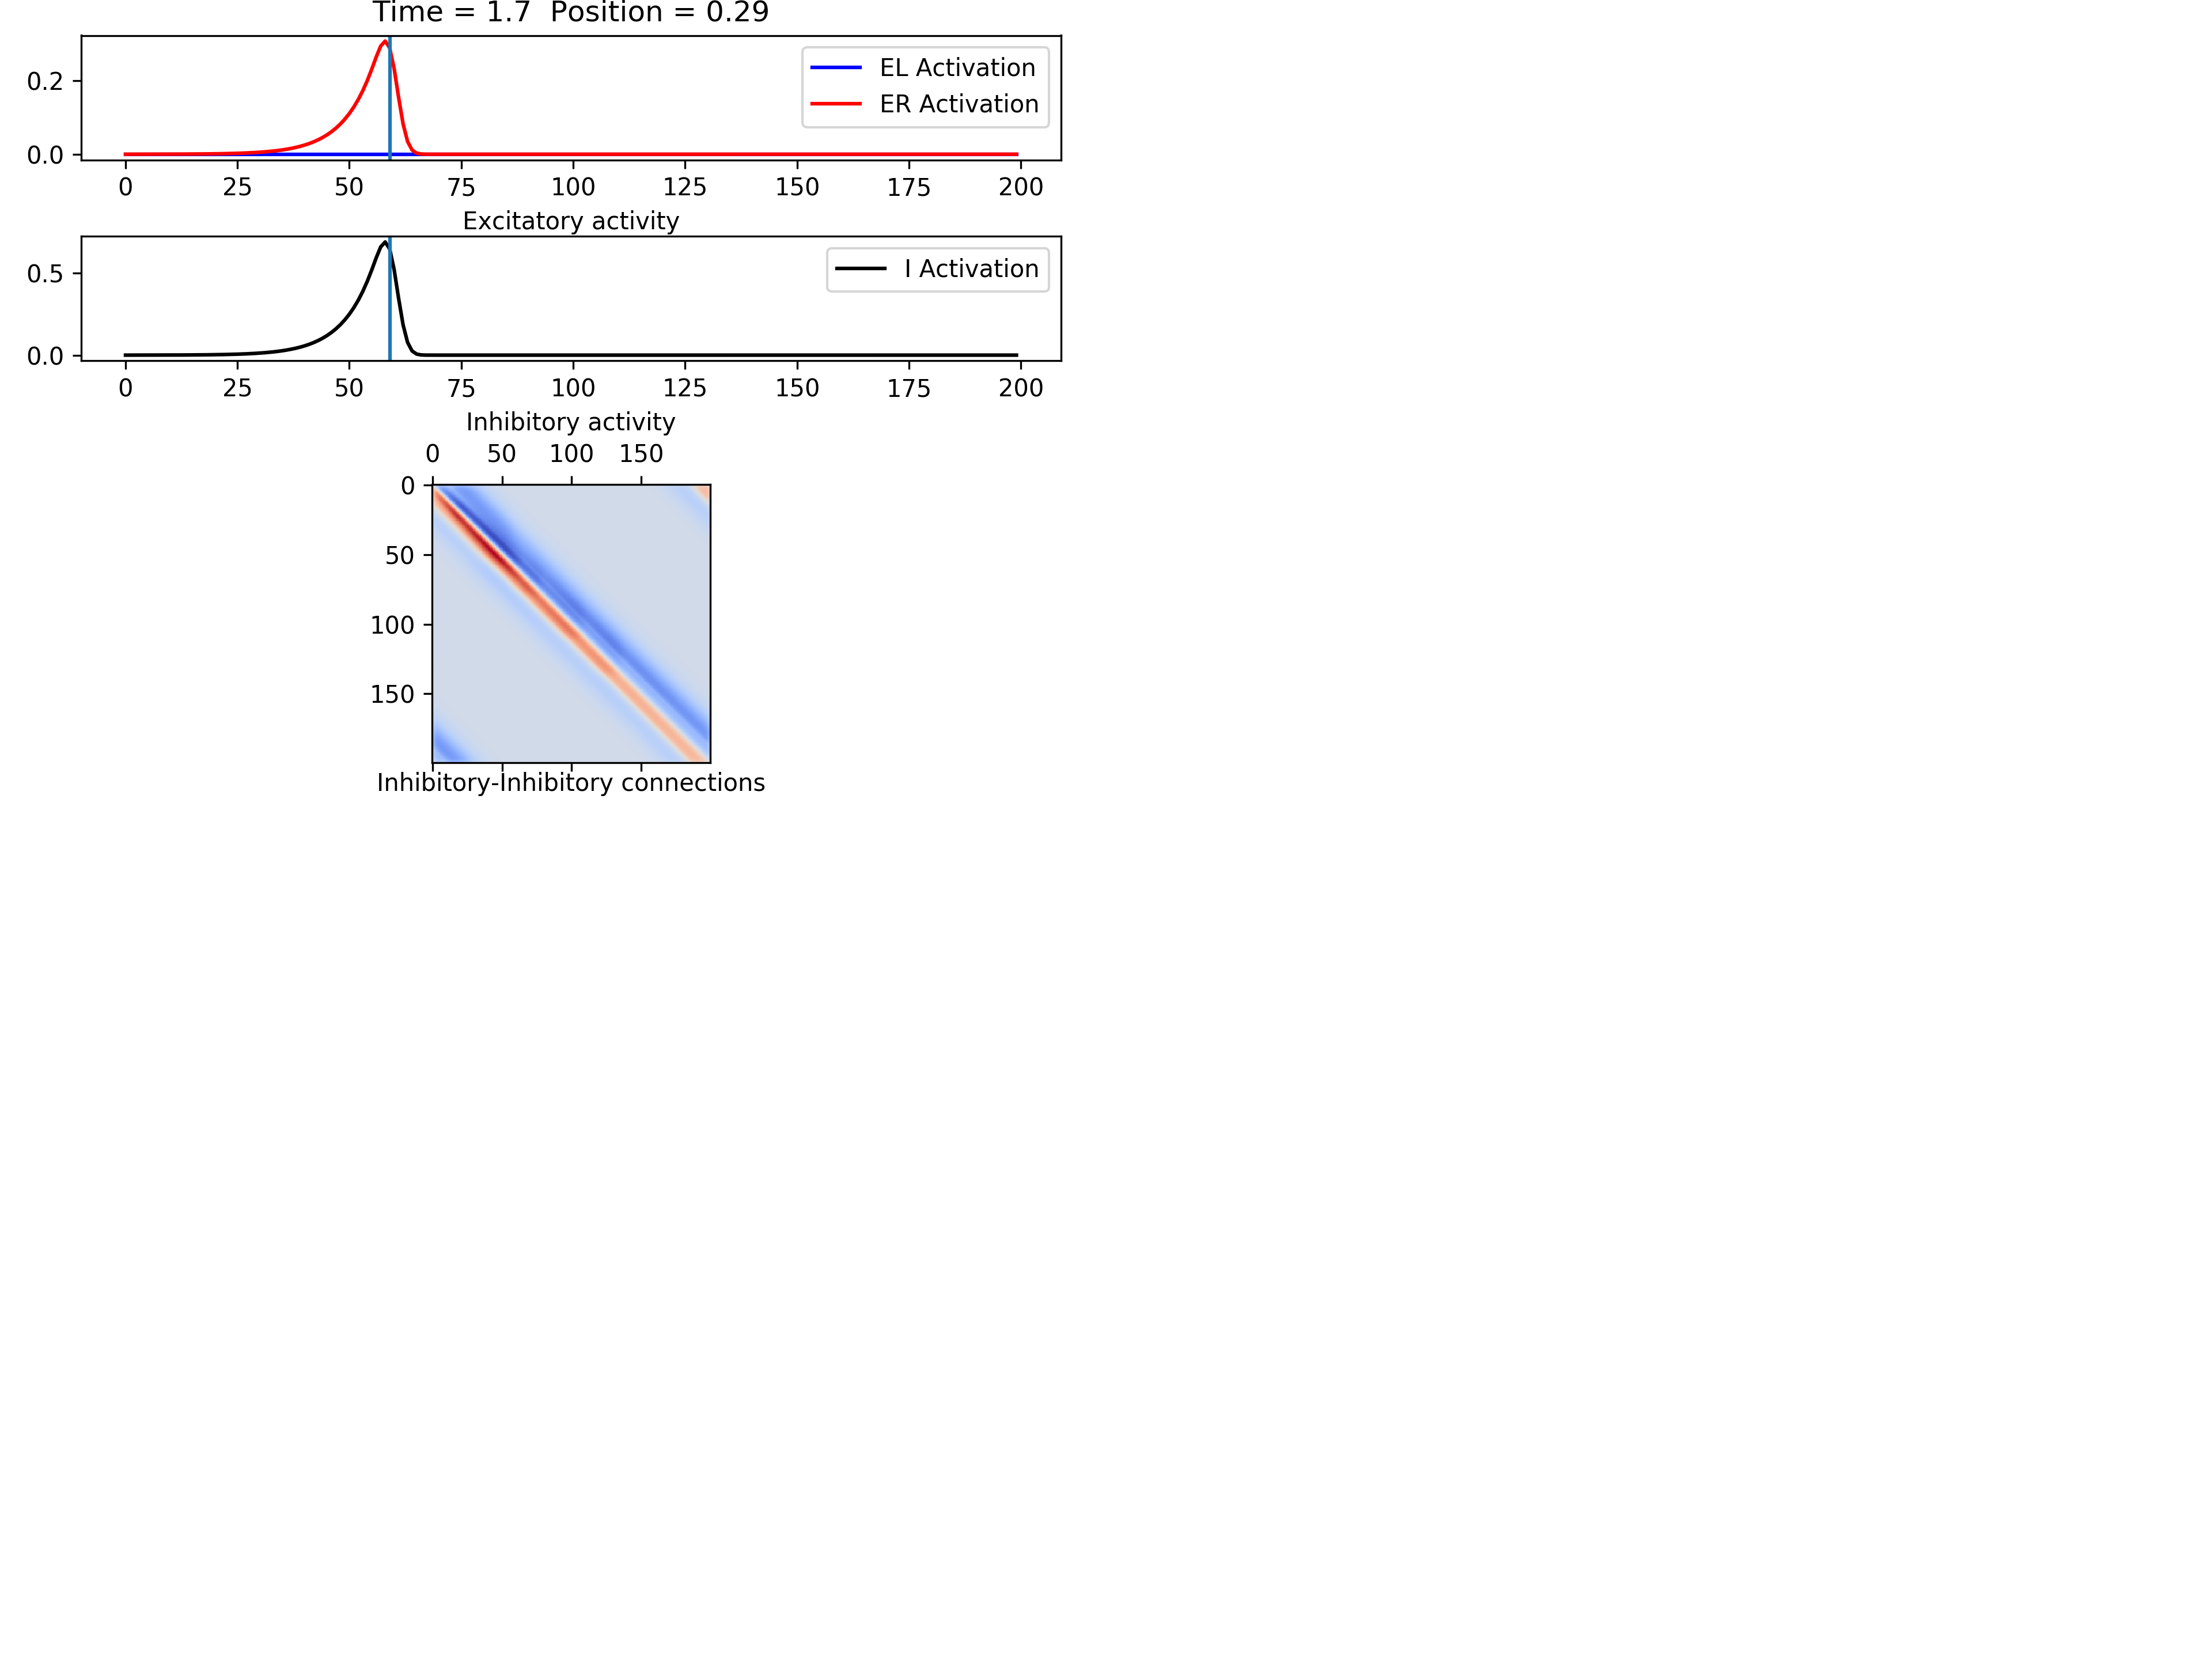

KeyboardInterrupt: 

In [113]:
# Do two sets of two passes, starting from the left first and then from the right.
# Doing two passes, with all activity being reset in between, helps to improve the
# invariance of the network.
network.learn(2, dir=1, periodic=True, recurrent=False)
network.plotting = False # The new plots look the same as the old ones.
network.learn(2, dir=-1, periodic=True, recurrent=False)
network.plotting = True

### Weight Patterns

Now, we can visualize the resulting weights more clearly.  Note that here we have enforced Dale's law, unlike in the above figures; this simply means that we have stopped inhibitory cells from having excitatory effects, and vice-versa.  This primarily affects the main diagonal in each figure.

<IPython.core.display.Javascript object>


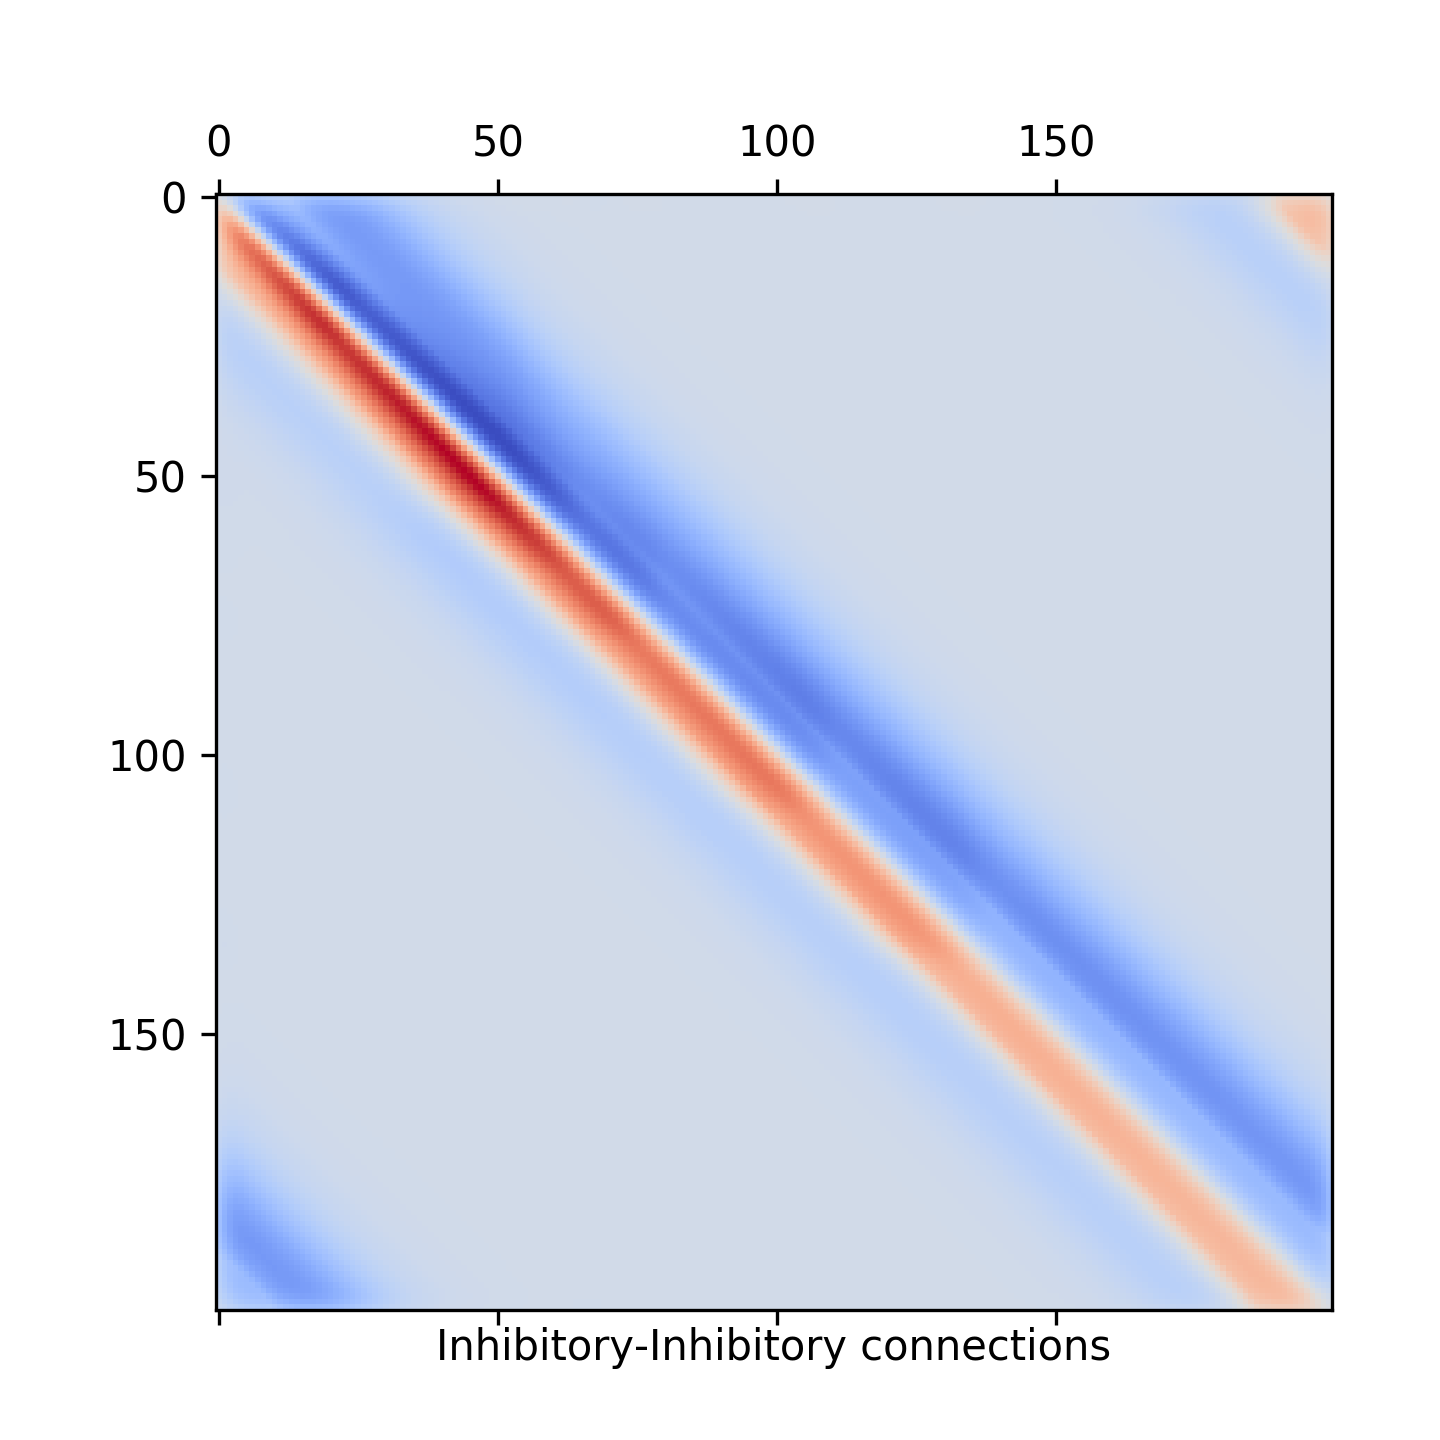

In [119]:
plt.matshow(network.weightsII, cmap=plt.cm.coolwarm)
plt.xlabel("Inhibitory-Inhibitory connections")
plt.show()

This I-I weight structure guarantees the stable, gridlike firing pattern exhibited by the network.  It is not, however, sufficient for path integration.  For that, we must have the left and right excitatory populations behave differently.  Fortunately, simply Hebbian learning causes this to be the case, both in their connections to the inhibitory cells and in the inhibitory cells' connections to them.

Note the asymmetry in the following weight structures.  The E-I connections have left excitatory cells drive inhibitory cells to their left (causing the pattern on the grid to shift right), while the right E-I connections do the reverse.  This does, unfortunately, represent path integrating backwards -- this is an unfortunate result of the Hebbian learning rules used.  To fix this, we would have to use anti-Hebbian STDP for the excitatory connections, which may or may not be plausible biologically.

<IPython.core.display.Javascript object>


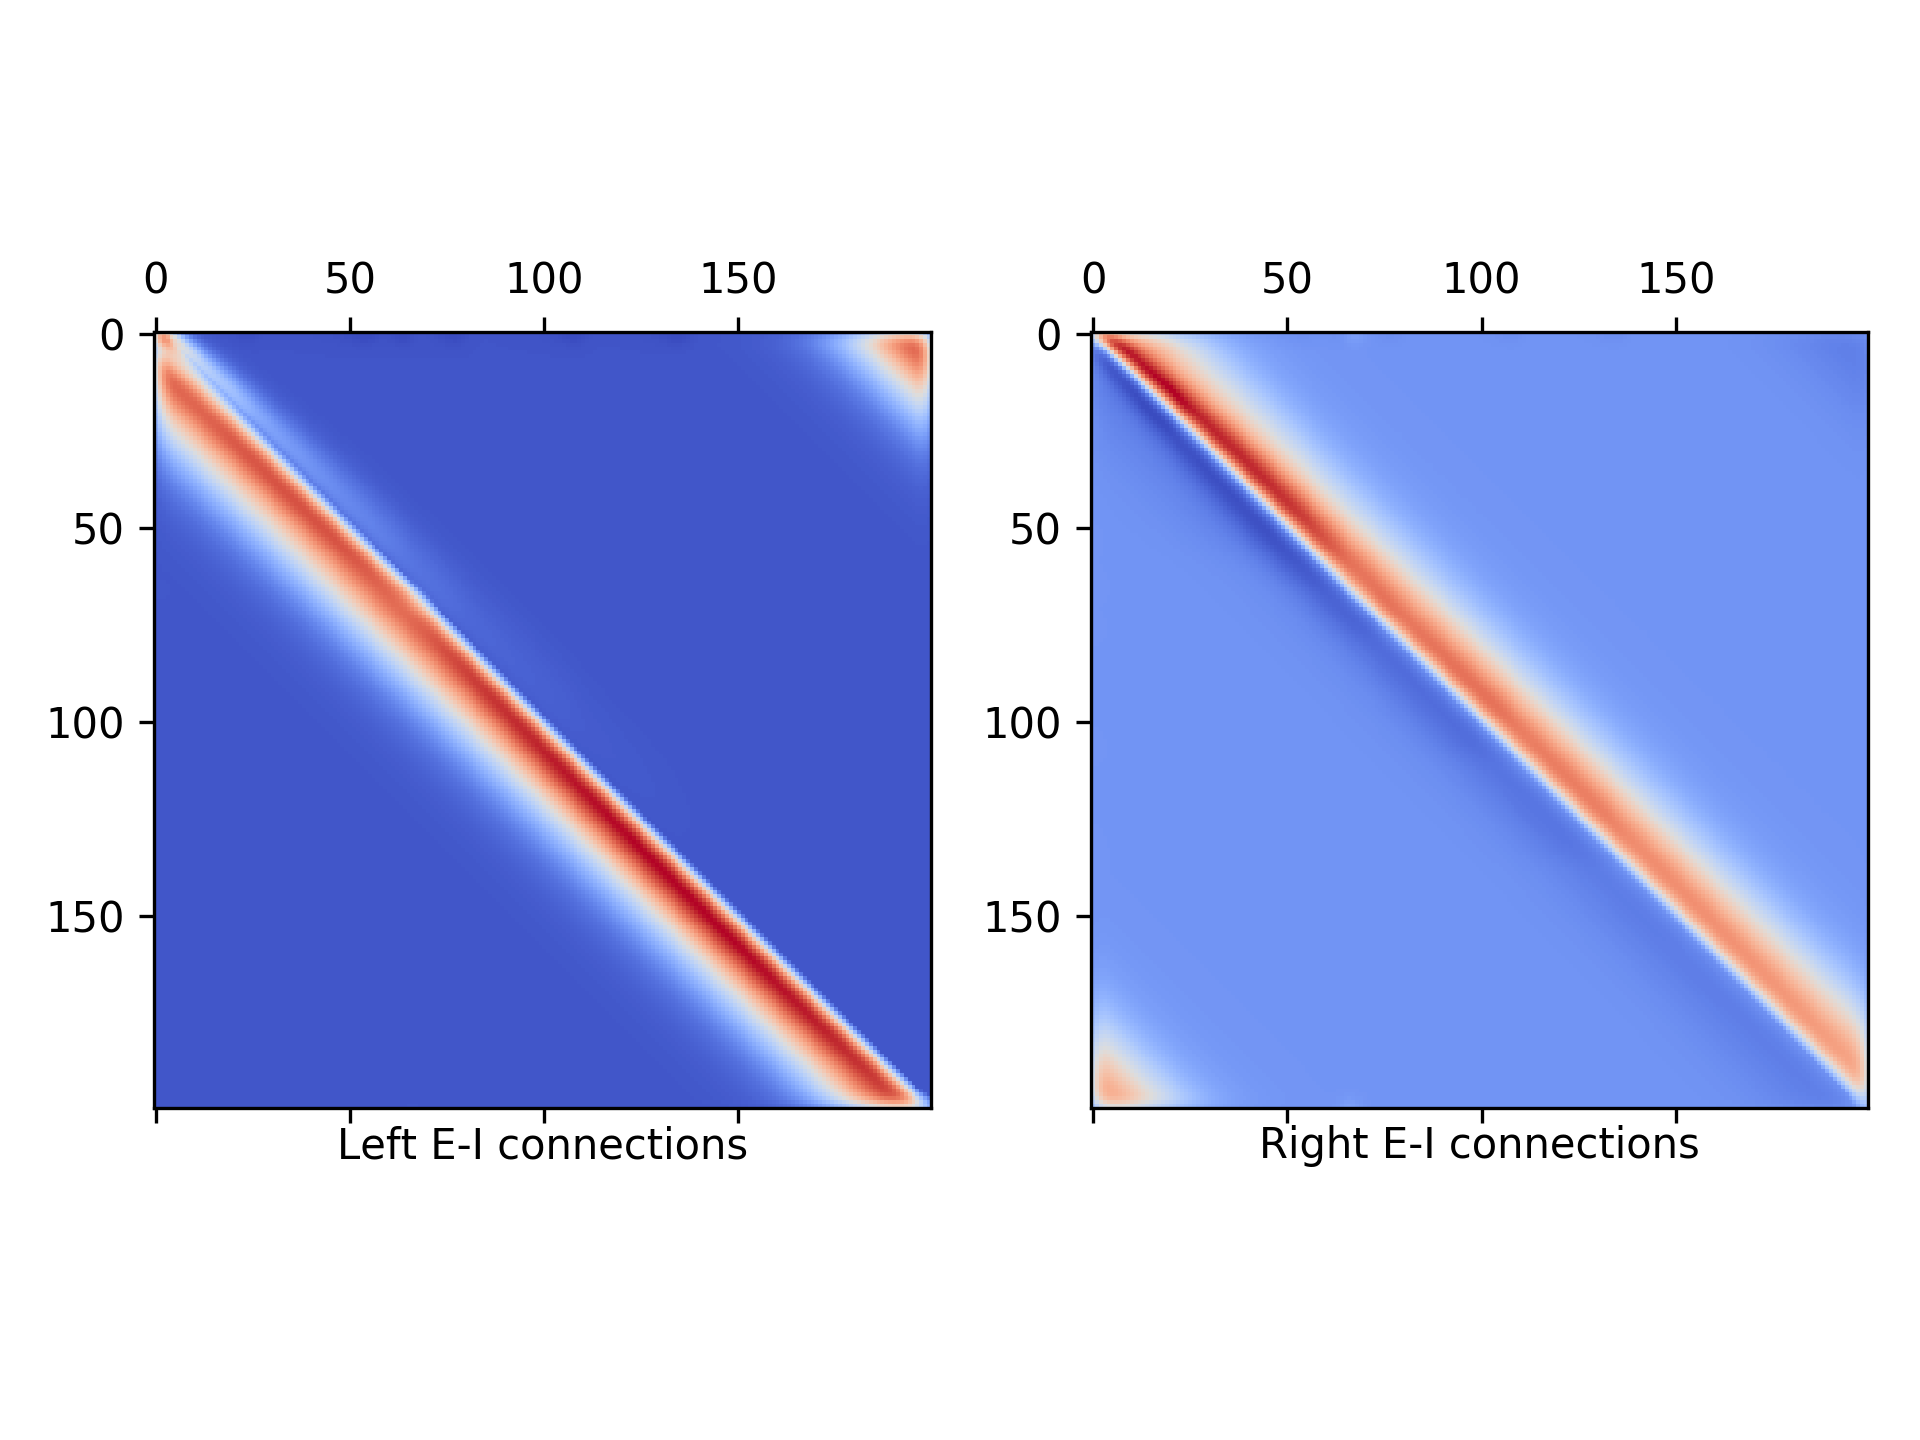

In [117]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.matshow(network.weightsELI, cmap=plt.cm.coolwarm)
ax1.set_xlabel("Left E-I connections")
ax2.matshow(network.weightsERI, cmap=plt.cm.coolwarm)
ax2.set_xlabel("Right E-I connections")
plt.tight_layout()
plt.show()

Here, we can see that a similar asymmetry is present in the inhibitory connections to the excitatory populations.  Inhibitory cells drive left E cells to their left, and right E cells to their right, enabling the network to shift.

<IPython.core.display.Javascript object>


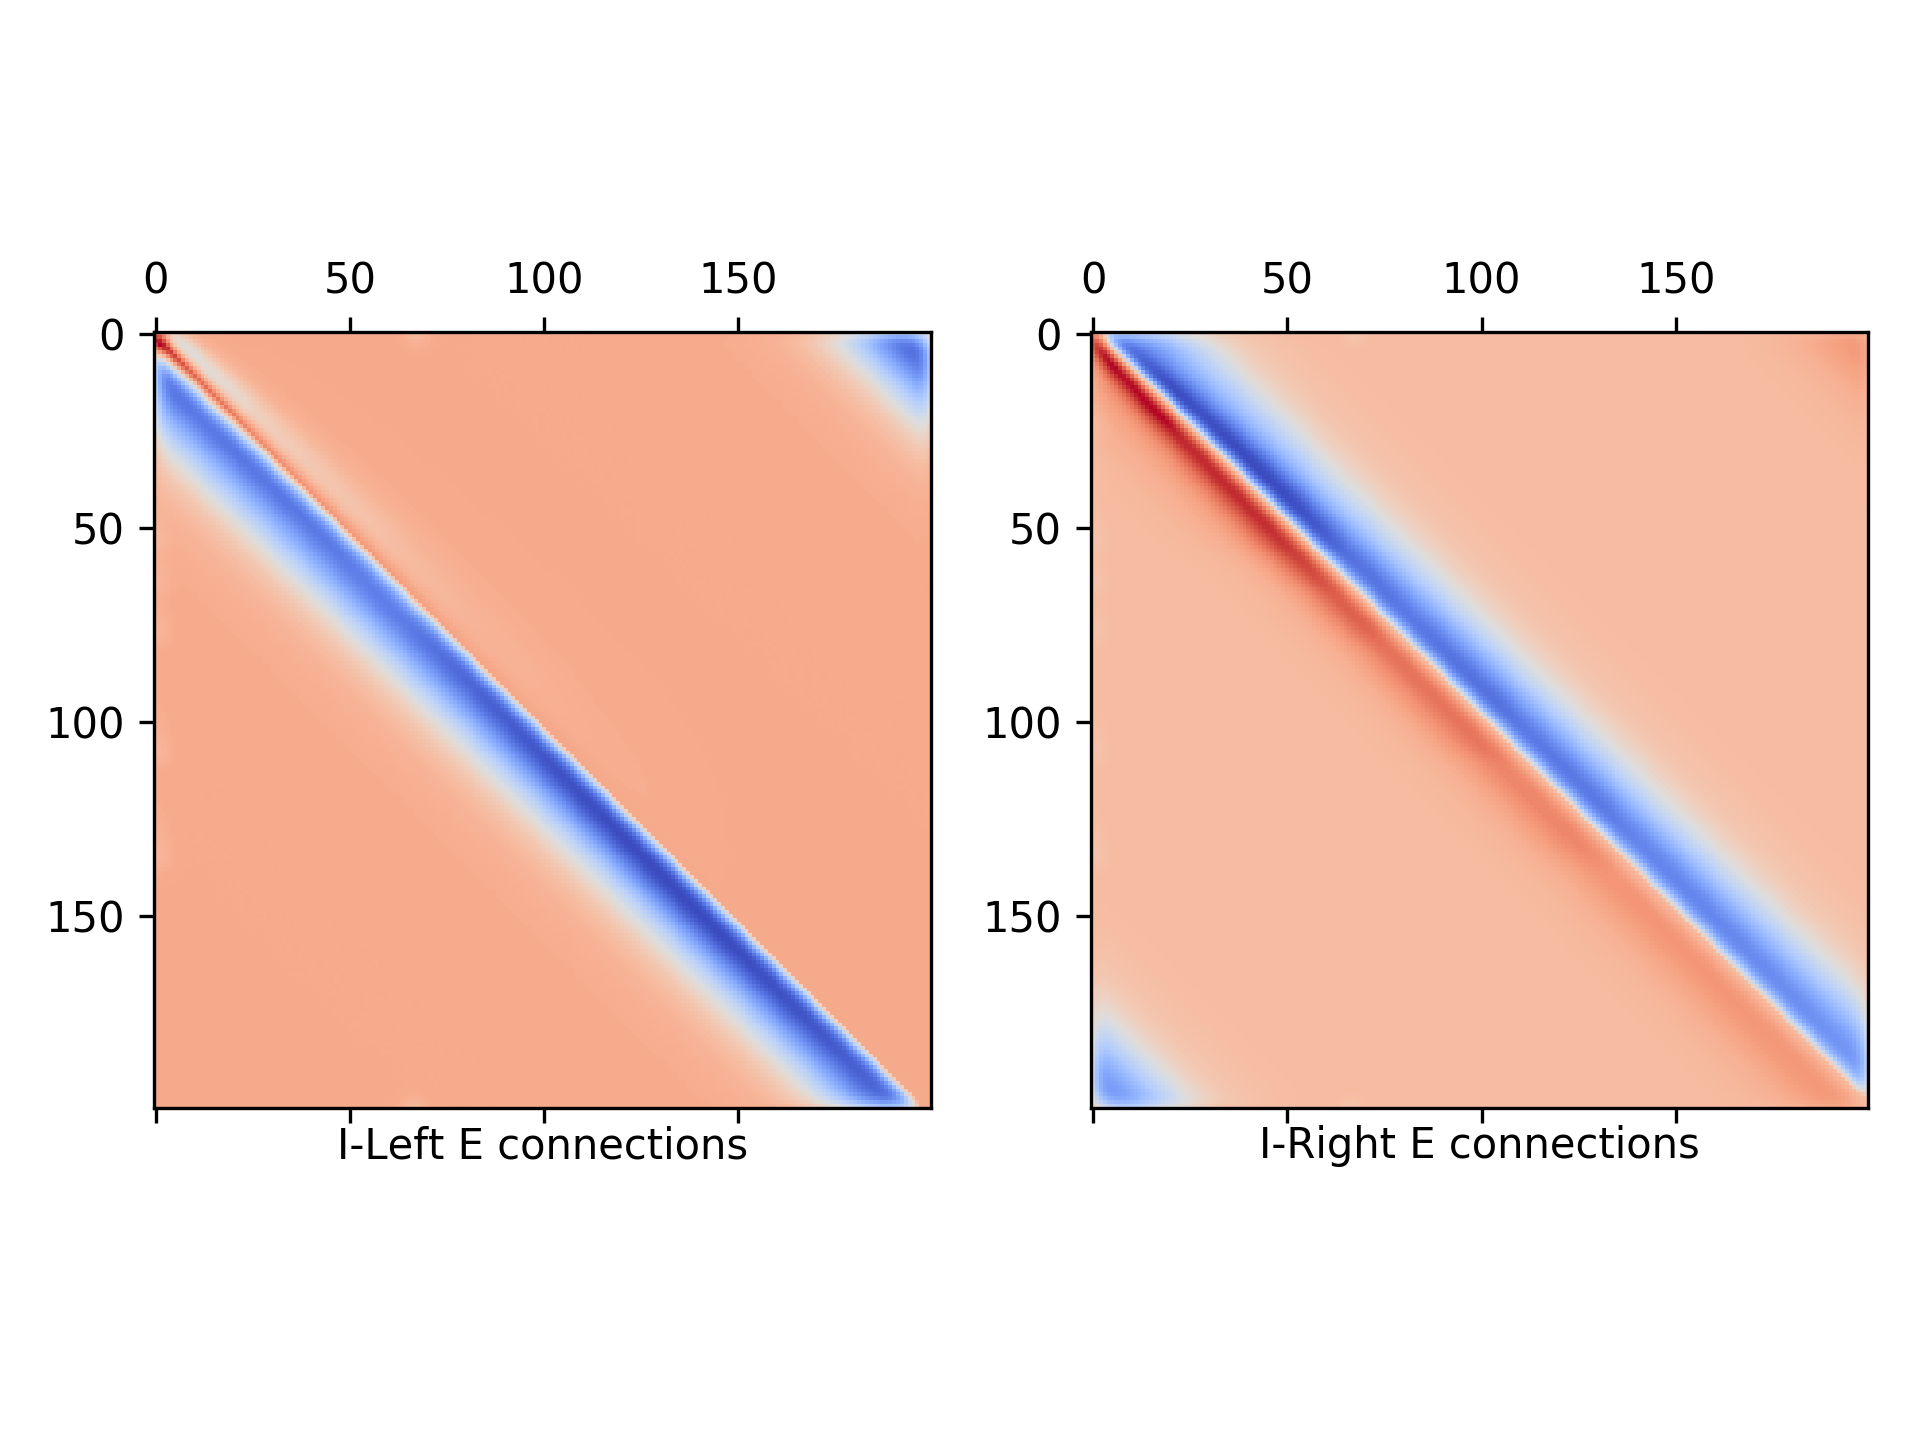

In [118]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.matshow(network.weightsIEL, cmap=plt.cm.coolwarm)
ax1.set_xlabel("I-Left E connections")
ax2.matshow(network.weightsIER, cmap=plt.cm.coolwarm)
ax2.set_xlabel("I-Right E connections")
plt.tight_layout()
plt.show()

## Simulations
We now simulate the network in two different modes; one where the animal is standing still, and one where the animal is moving.  In the first case, we show that the continuous attractor network produces a stable network with multiple firing fields, and in the second we show that the continuous attractor network is capable of conducting accurate path integration.

<IPython.core.display.Javascript object>


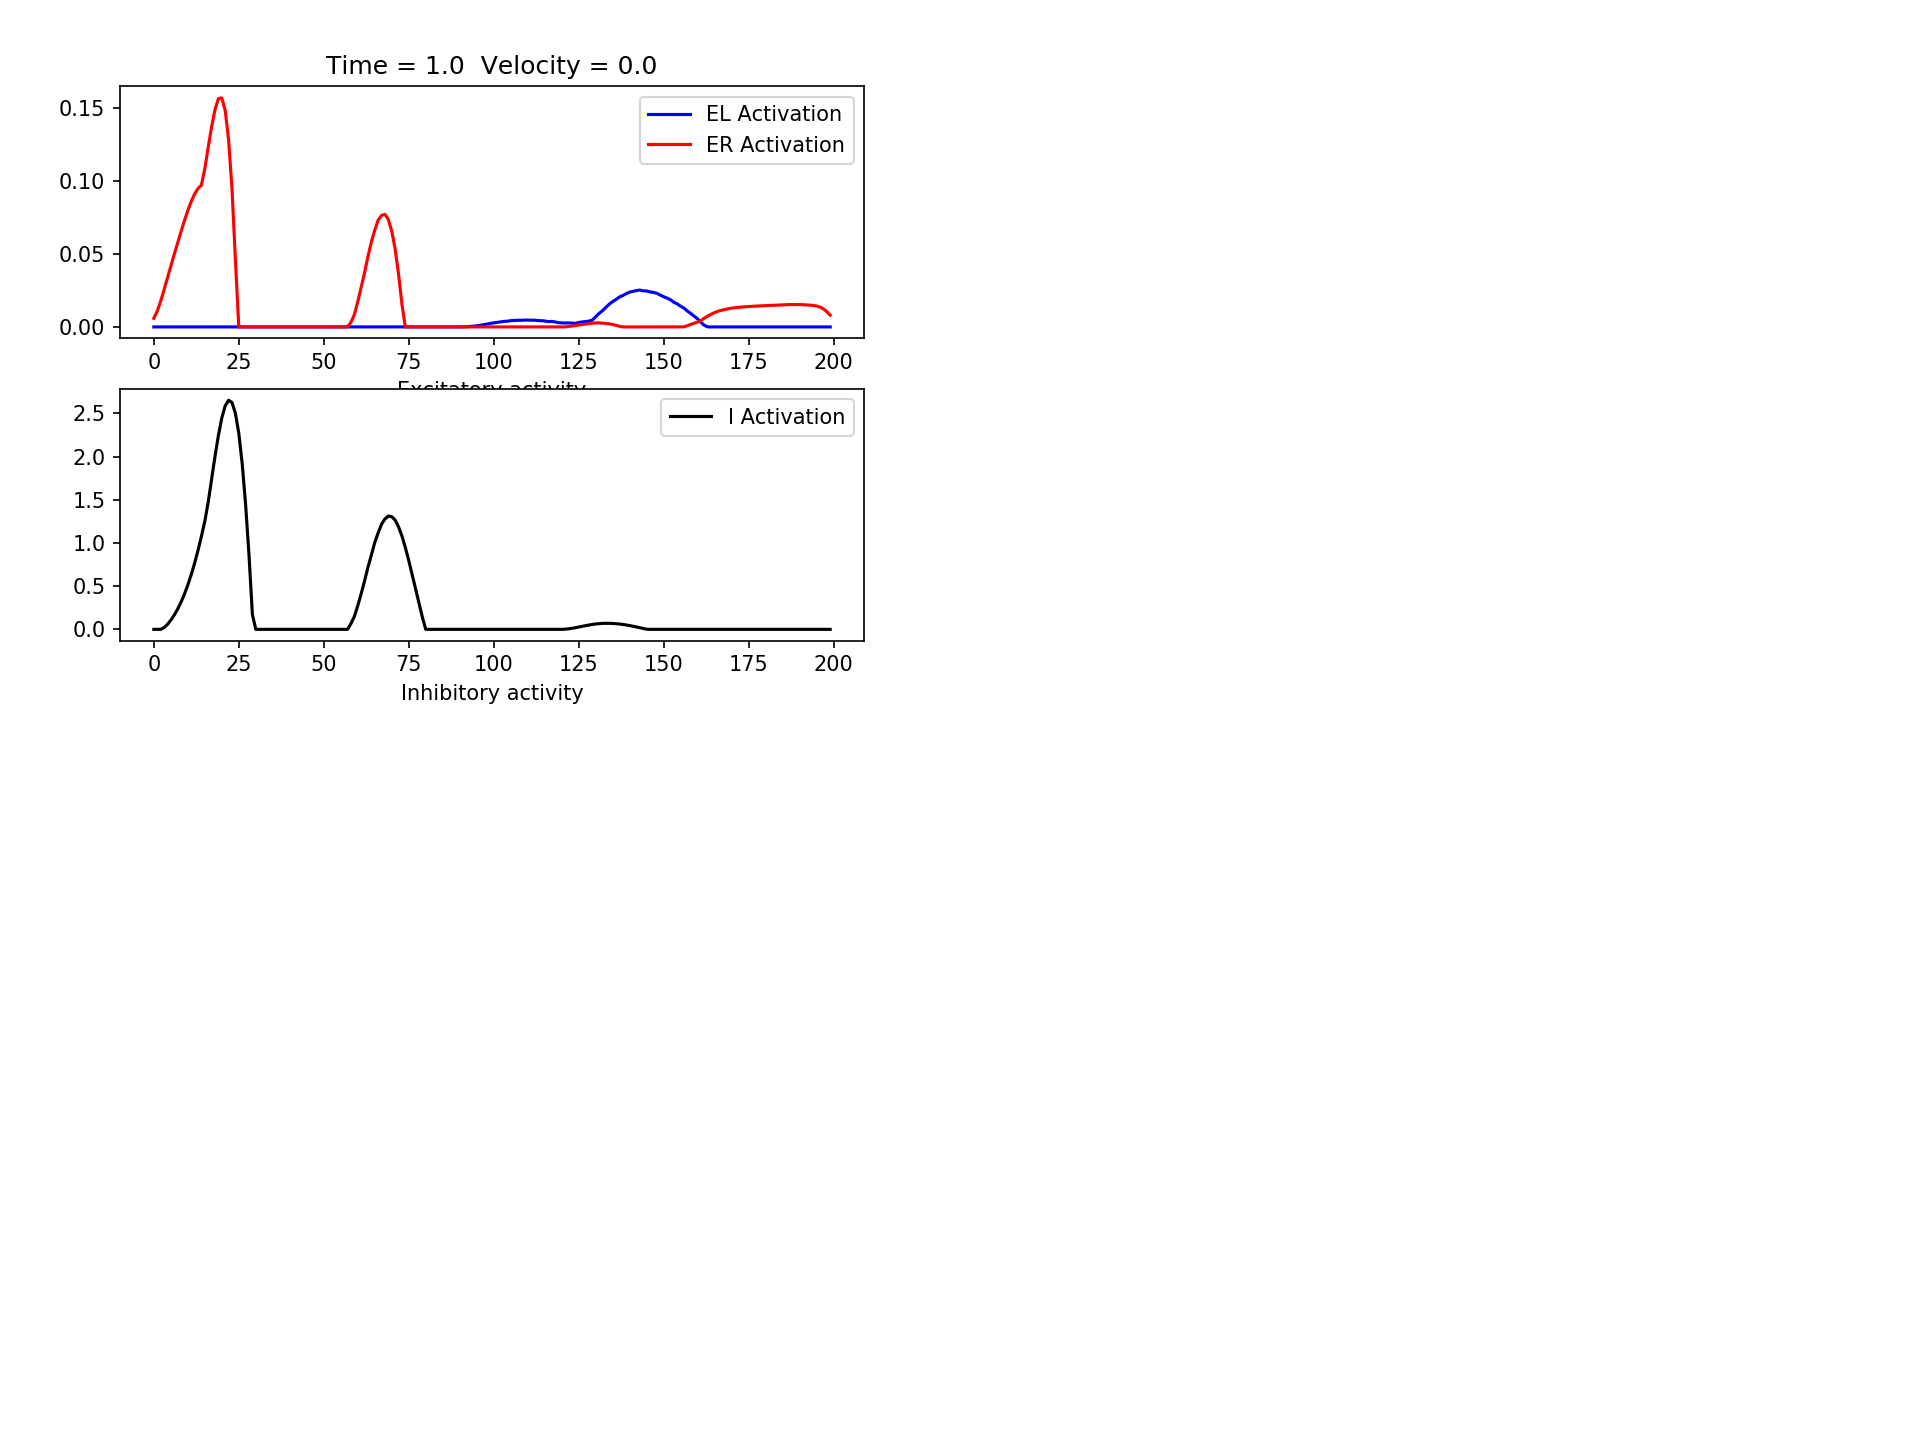

KeyboardInterrupt: 

In [126]:
network.simulate(time=10, 
                 feedforwardInputI=np.ones((200,)), # The global input to give all inhibitory cells.  Constant.
                 feedforwardInputE=np.ones((200,)), # Also constant for excitatory cells.
                 v=0.0, # Standing still
                 dt=0.001, # Use a smaller time step for simulation, for stability
                 recurrent=True, # Recurrent connections should now be active
                 inputNoise=None, # Noise can be added to the input without compromising results.
                                  # Try using a noise value of 2.
                 )

Now, we simulate path integration as the animal moves along a somewhat irregular trajectory in a much larger environment.  In the first two figures we show the activation of the excitatory and inhibitory cells; in the third, we show our estimate for the movement of the animal, measured in cells.  Note that the grid cell network path integrates backwards.  As before, we can add noise without compromising results.

<IPython.core.display.Javascript object>


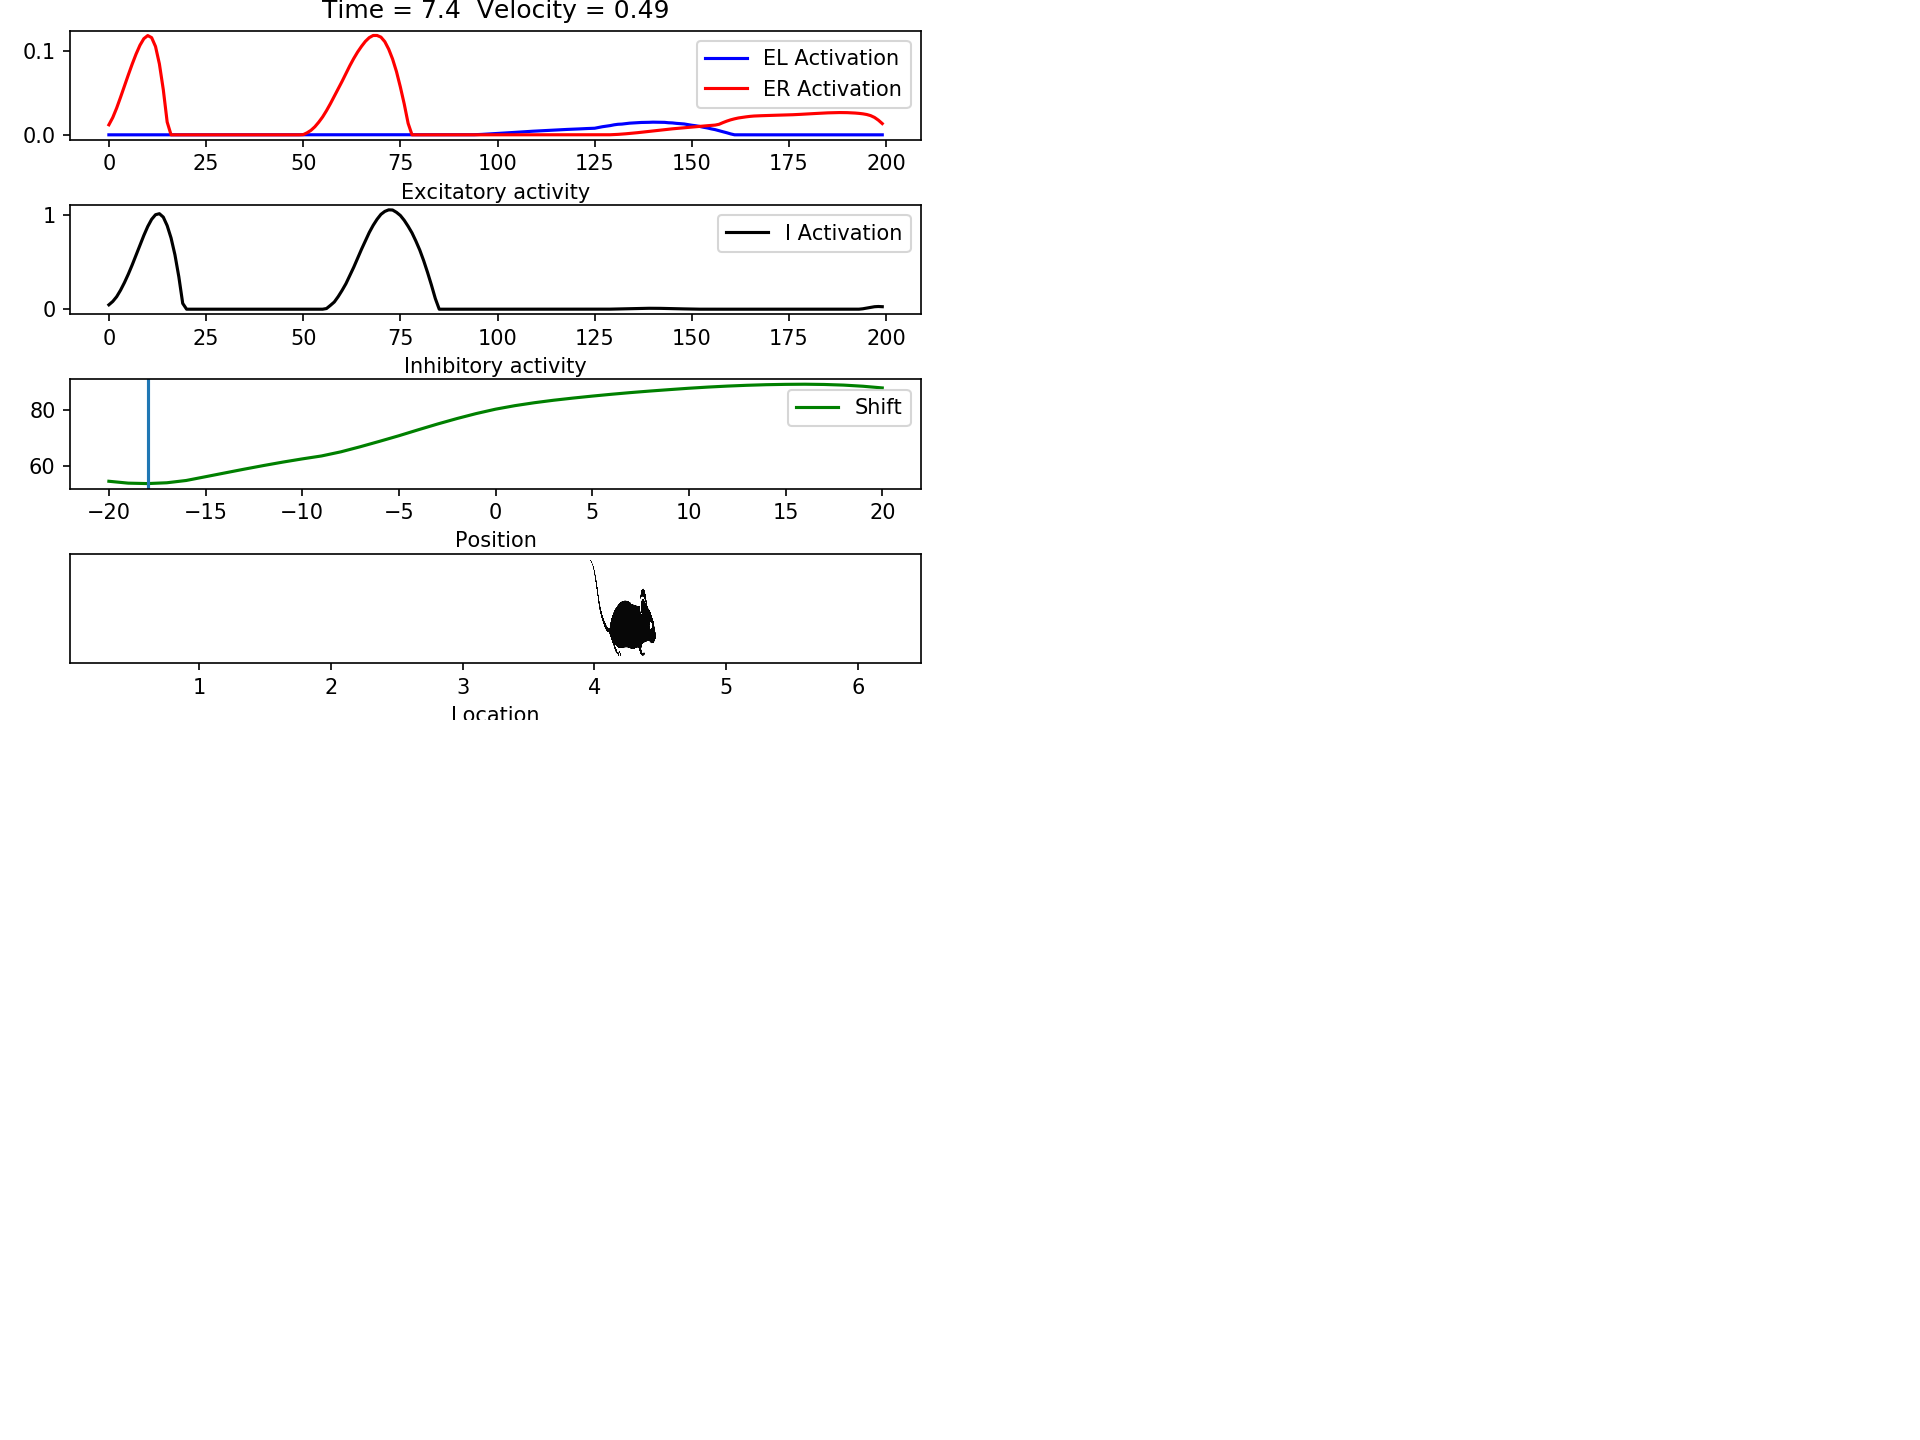

KeyboardInterrupt: 

In [135]:
plt.rcParams['figure.dpi'] = 300
trueVelocities, estimatedVelocities = network.calculatePathIntegrationError(time=25,
                                                                            dt=0.001,
                                                                            inputNoise=None,
                                                                            )

## Assessment
We can assess the quality of the path integration performed by measuring the correlation between movement in the grid cell module and true movement.  In general, this correlation is extremely tight, with r^2 above 0.95 for most settings of the network.

<IPython.core.display.Javascript object>


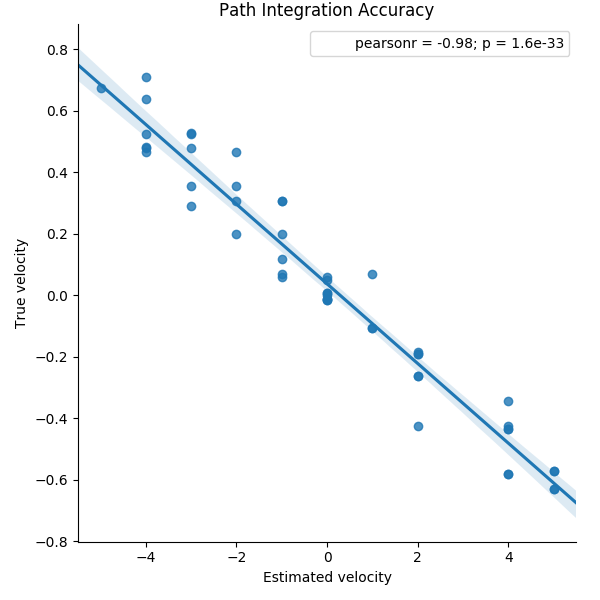

In [72]:
g = sns.JointGrid(np.asarray(estimatedVelocities), np.asarray(trueVelocities), ratio=100)
g.plot_joint(sns.regplot)
g.annotate(stats.pearsonr)
g.ax_marg_x.set_axis_off()
g.ax_marg_y.set_axis_off()
plt.title("Path Integration Accuracy")
plt.xlabel("Estimated velocity")
plt.ylabel("True velocity")
plt.tight_layout()
plt.show()

That said, there are still substantial errors in the network's path integration.  Simply using linear regression to attempt to reconstruct the movements of the animal results in an average error that is roughly 20% of the animal's average movement speed, meaning that path integration without constant sensory reanchoring will be at best very imprecise.

In [73]:
model = LinearRegression().fit(estimatedVelocities.reshape(-1, 1), trueVelocities)
predictedValues = model.predict(estimatedVelocities.reshape(-1, 1))
print("RMSE is {}".format(np.sqrt(np.mean((predictedValues - trueVelocities)**2))))
averageError = np.mean(np.abs(predictedValues - trueVelocities))/np.mean(np.abs(trueVelocities))
print("Average error is {}% of average movement speed".format(str(averageError*100)[:4]))

RMSE is 0.0825068495163
Average error is 21.5% of average movement speed


## Conclusion
This work by Widloski & Fiete is of great importance; they provide one of the first reasonable demonstrations of how a CAN-like grid cell network could be learned using only simple learning rules over a small amount of time (they estimate that <24 hours of exploration would be sufficient, even in a 2D case).  The grid cell networks that result generally conform to our expectations of grid cell networks in almost every way, possessing gridlike firing fields, stable activation patterns when movement is not present, and reasonably-accurate path integration.

That said, this approach possesses a number of limitations.  As mentioned, the grid cell modules produced by this learning method path-integrate backwards, which while not a fatal flaw is quite undesirable.  

Moreover, the grid cells do not actually have their grid-like connections active while they are learning; during training, they function almost purely as place cells.  This is also highly undesirable, as it is not entirely plausible that these connections would be fully disabled during all learning.  Enabling them, meanwhile, tends to result in horrible numerical divergence, even with clipping.

Finally, the current learning process requires that grid cells begin as, effectively, place cells that are uniformly distributed across the environment.  This is also a deeply questionable assumption -- place cells are not uniform, and it would be ideal for gridlike firing fields to emerge gradually during training, not only after training is complete.